# Análisis Factorial Exploratorio (AFE) de variables continuas con R:
El Análisis Factorial Exploratorio (AFE) es un método para reducir la dimensionalidad de un conjunto de variables/indicadores, es decir, es un método para resumir la información. En este sentido, puede confundirse con el Análisis de Componentes Principales (ACP).

El ACP parte de la varianza total para encontrar combinaciones lineales entre las variables originales que expliquen la mayor parte de dicha varianza total. Así, el primer componente principal sería aquella combinación lineal de variables que explica un mayor porcentaje de varianza total; el segundo componente principal sería aquel que explica la mayor proporción de varianza no explicada por el primero, y así sucesivamente.Al aplicar ACP a un conjunto de datos conseguimos pues resumir la información en unas pocas componentes principales. Dichas componentes principales, al ser combinaciones lineales de variables, resultan, muchas veces, difíciles de interpretar.

Por su parte, el AFE distingue entre varianza común y varianza específica. La varianza común o compartida es aquella parte de la variabilidad total de los datos que está compartida entre las variables; mientras, la varianza no compartida es la específica de cada variable. Los factores comunes son, por tanto, variables subyacentes - no observadas - que explican la asociación entre las variables.

Asimismo, desde el punto de vista de las variables, decimos que la comunalidad de una variable es la parte de su varianza explicada por los factores comunes. Por ello, interesa que este dato sea alto. Por el contrario, la especificidad es la parte de variabilidad de una variable específica de dicha variable. Esta última conviene pues que sea baja.

Los factores sí suelen tener una interpretación más sencilla que los componentes principales. Asimismo, mientras los componentes principales, por definición, no están correlacionados, los factores pueden estarlo.

El AFE suele utilizarse con datos procendentes de encuestas sociales, psicológicas o sanitarias, sin embargo, también puede aplicarse a otros tipos de datos, como los que utilizamos en este caso.





## Librerías:
Al usar R en Google Colab debemos:
1.   Instalar los paquetes/librerías (**install.packages("paquete")**) una vez cada vez que abramos el cuaderno de nuevo. Algunos paquetes ya  instalados por defecto en Colab, por lo que debemos pasar directamente al siguiente paso.
2.   Llamar a los paquetes/librerías (**library(paquete)**) una vez cada vez que abramos el cuaderno de nuevo - y tras haberlos instalado.

In [ ]:
library(MASS) #Para simular datos que sigan una normal multivariante con la función mvrnorm()
install.packages("psych") #Para realizar el AFE, el Análisis Paralelo y otras operaciones como el test de Mardia o el KMO
library(psych)
install.packages("ggcorrplot") #Para graficar las correlaciones obtenidas mediante un mapa de calor
library(ggcorrplot)
install.packages("GPArotation") #Para poder rotar los factores
library(GPArotation)

## Datos:
Vamos a simular unos datos con supuesta información de 1000 jugadores de fútbol. Estos datos contienen información sobre su altura, peso, ganancias y edad.

Los vamos a simular de tal forma que las variables Altura y Peso estén fuertemente correlacionadas y lo mismo para las variables Ganancias y Partidos. Debido a ello, la estructura factorial teórica presenta dos factores: Altura-Peso y Ganancias-Partidos.

In [ ]:
set.seed(1000) #Establecemos una semilla para facilitar la reproductibilidad de los resultados

cov_Altura_Peso        <- 0.7*sqrt((20^2)*(15^2)) #La covarianza entre X e Y es igual al producto de su correlación por sus desviaciones típicas
cov_Ganancias_Partidos <- 0.8*sqrt((150^2)*(50000^2))

cov_matriz <- rbind(c(            20^2, cov_Altura_Peso,                      0,                      0),
                    c( cov_Altura_Peso,            15^2,                      0,                      0),
                    c(               0,               0,                50000^2, cov_Ganancias_Partidos),
                    c(               0,               0, cov_Ganancias_Partidos,                  150^2))

mu <- c(170, 75, 250000, 400)

datos_correlados <- as.data.frame(mvrnorm(n=5000, mu=mu, Sigma=cov_matriz))

datos_AFE <- data.frame(
  Altura    = round(abs(datos_correlados[,1]),2), #La altura sigue una normal N(170, 20). Usamos la función abs() (valor absoluto), para evitar alturas negativas
  Peso      = round(abs(datos_correlados[,2]),2), #El peso sigue una normal N(75, 15)
  Ganancias = round(abs(datos_correlados[,3]),2), #Los ingresos siguen una normal N(250000, 50000)
  Partidos  = round(abs(datos_correlados[,4]),2)  #Los partidos siguen una normal N(400, 150)
)

head(datos_AFE)

,Altura,Peso,Ganancias,Partidos
,<dbl>,<dbl>,<dbl>,<dbl>
1,190.95,83.26,227710.6,546.42
2,163.09,69.68,189707.2,227.93
3,168.71,67.31,252056.0,545.05
4,168.29,77.24,281969.7,376.18
5,190.45,92.66,210672.2,351.59
6,122.78,42.16,230725.4,399.56


###Paso 1: Estimación de la matriz de correlaciones.
Dependiendo del tipo de datos que tengamos, debemos utilizar un tipo de correlación u otro:
* Datos continuos: La matriz de correlaciones de Pearson y la de Spearman son las más apropiadas ante continuos o ante datos ordinales (categóricos) con más de 7 categorías de respuesta (tienden a la continuidad).
* Datos categóricos/ordinales: la matriz de correlaciones policórica es la más recomendada ante datos ordinales de 7 o menos categorías de respuesta. Si tuviéramos datos dicotómicos, la matriz a emplear sería la matriz tetracórica (similar a la policórica pero con datos dicotómicos).

En nuestro caso, como tenemos datos continuos, usaremos la matriz de correlaciones de Pearson.

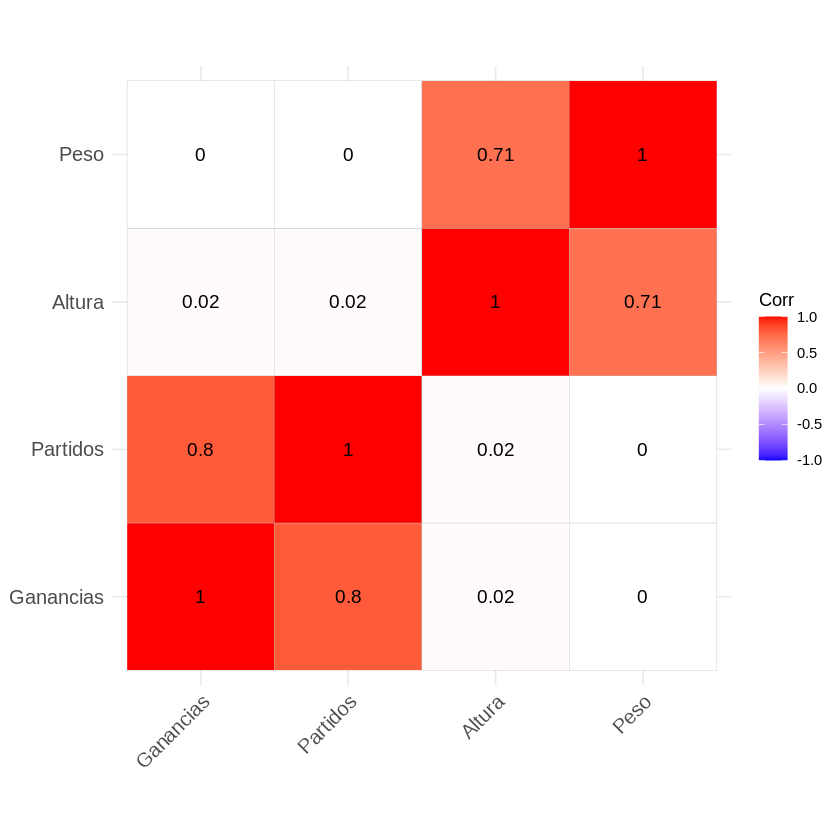

In [ ]:
matriz_correlaciones <- cor(datos_AFE, method = "pearson")
ggcorrplot(matriz_correlaciones,hc.order = T, lab=T)

Como esperábamos, vemos que Altura y Peso están bastante correlacionadas (r=0,71), y lo mismo ocurre con Ganancias y Partidos (r=0,8).

### Paso 2: Verificar que la matriz sea factorizable (es decir, que tiene sentido hacer un AFE con nuestros datos):
(Si la matriz no fuese factorizable, la relación entre las variables sería tan baja que no se formarían factores).

Entre los métodos para comprobar si la matriz es factorizable destacan:
* Test de esfericidad de Bartlett: se pregunta si la matriz de correlaciones es o no la matriz identidad. Si la matriz de correlaciones es la matriz identidad, las variables no estarían correlacionadas y no habría varianza compartida de la que extraer los factores (no habría factores comunes). Si rechazamos la hipótesis nula (la matriz de correlaciones es la matriz identidad), la matriz será factorizable.
* Medida KMO (Kaiser-Meyer-Olkin): expresa el grado de predicción de las variables a partir de las demás. Su valor oscila entre 0 y 1. Cuanto mayor sea, mejor. Valores a partir de 0,5 se consideran aceptables.
* Calcular el determinante de la matriz de correlaciones: valores cercanos a cero indican que la matriz es factorizable.

In [ ]:
#Test de esfericidad de Bartlett:
p_esf <- cortest.bartlett(matriz_correlaciones, n=nrow(datos_AFE))
cat("El p-valor del test de esfiricidad de Bartlett es: ", p_esf$p.value)
#KMO:
KMO(matriz_correlaciones)
#Determinante de la matriz:
cat("El valor del determinante de la matriz es: ", det(matriz_correlaciones))

El p-valor del test de esfiricidad de Bartlett es:  4.971917e-88

Kaiser-Meyer-Olkin factor adequacy
Call: KMO(r = matriz_correlaciones)
Overall MSA =  0.5
MSA for each item = 
   Altura      Peso Ganancias  Partidos 
      0.5       0.5       0.5       0.5 

El valor del determinante de la matriz es:  0.1833664

1. El p-valor es menor a los niveles de significación habituales(10%, 5% y 1%) por lo que rechazamos la hipótesis nula: la matriz de correlaciones no es la matriz identidad.
2. El resultado del KMO es de 0,5.
3. El determinante tiene un valor no excesivamente bajo: 0.194728602740068

En general, los test no arrojan resultados óptimos, pero continuamos adelante con el AFE.



### Paso 3: determinar un método de extracción de factores:
La ecuación del modelo factorial es la siguiente:

\begin{align}
X_j = a_{j1}F_1 + a_{j2}F_2
+ ... +a_{jn}F_n + u_j
\end{align}

Donde $X_j$ (variable j) es una combinación lineal de factores comunes y del factor único (especificidad). Los $a_{jh}$ son los pesos factoriales, que representan la importancia que cada factor común tiene en explicar la variable $X_j$.

El objetivo de los métodos de extracción de factores es reproducir, con el mínimo error, la matriz de correlaciones a partir de la matriz de pesos factoriales.

Existen varios métodos de extracción de factores. Los más comunes son:
*   Máxima Verosimilitud (*Maximum Likelihood*, ML). Para utilizarlo, nuestros datos deben seguir una normal multivariante (lo que podemos comprobar realizando el test de Mardia, por ejemplo). Estadísticamente es el más adecuado, pues es asintóticamente insesgado, eficiente y consistente.
*   Mínimos Cuadrados No Ponderados (*Unweighted Least Squares*, ULS) (También llamado Residuos Mínimos, MinRes). No requiere de la existencia de normalidad multivariante.
* Ejes principales. Tampoco requiere de datos que sigan una normal multivariante.
* Componentes principales. Como hemos dicho en la introducción, no es método de ánalisis factorial propiamente dicho, ya que su objetivo es intentar explicar toda la varianza, y no solo la varianza común o compartida. Sin embargo, su uso, aunque no se recomiende, está bastante extendido, pues es la opción por defecto de muchos programas estadísticos.

En principio, nuestros datos deben seguir una normal multivariante ya que así los hemos simulado, por lo que podríamos emplear el método ML. De todas formas, vamos a realizar el test de Mardia para comprobarlo.




Call: mardia(x = datos_AFE, na.rm = TRUE)

Mardia tests of multivariate skew and kurtosis
Use describe(x) the to get univariate tests
n.obs = 5000   num.vars =  4 
b1p =  0.02   skew =  19.32  with probability  <=  1
 small sample skew =  19.34  with probability <=  1
b2p =  23.73   kurtosis =  -1.35  with probability <=  0.18

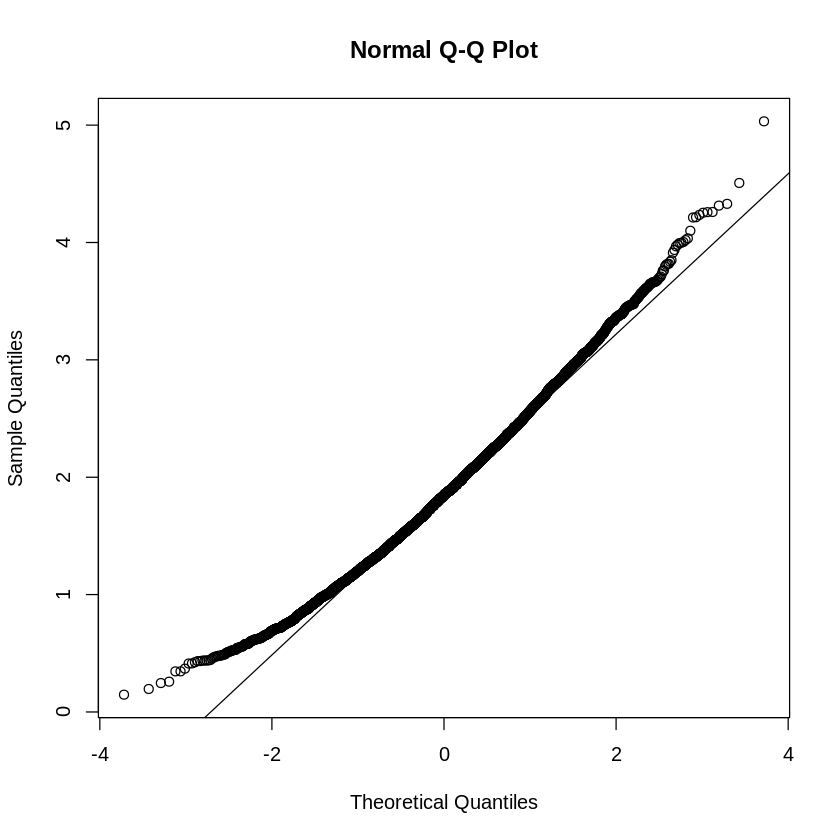

In [ ]:
#Test de Mardia de normalidad multivariante:
mardia(datos_AFE, na.rm = TRUE)

Como los p-valores son superiores a los niveles de significación habituales (10%, 5% y 1%) no se rechaza la hipótesis nula del test de Mardia, es decir, no se rechaza la normalidad multivariante de los datos. Por tanto, podemos usar Máxima Verosimilitud.

### Paso 4: Determinamos el número de factores a extraer:
Existen cuatro métodos principales:
* Regla de Kaiser: se deben aceptar todos aquellos factores con un autovalor mayor a 1.
* Gráfico de sedimentación (*scree plot*): gráfico donde podemos ver cómo disminuye la varianza explicada o el autovalor a medida que vamos aumentando el número de factores a extraer. Se complementa muy bien con la regla de Kaiser.
* Establecimiento de un porcentaje de varianza explicada mínimo (por ejemplo, el 75%): cogeríamos todos los factores necesarios para explicar ese porcentaje mínimo de varianza.
* Análisis paralelo (AP, método recomendado): el AP parte de generar nuevas muestras aleatorias (mínimo 100) con el mismo número de variables y observaciones que la muestra original y, a partir de ello, se queda con aquellos factores cuyo autovalor es superior a los generados por azar. 

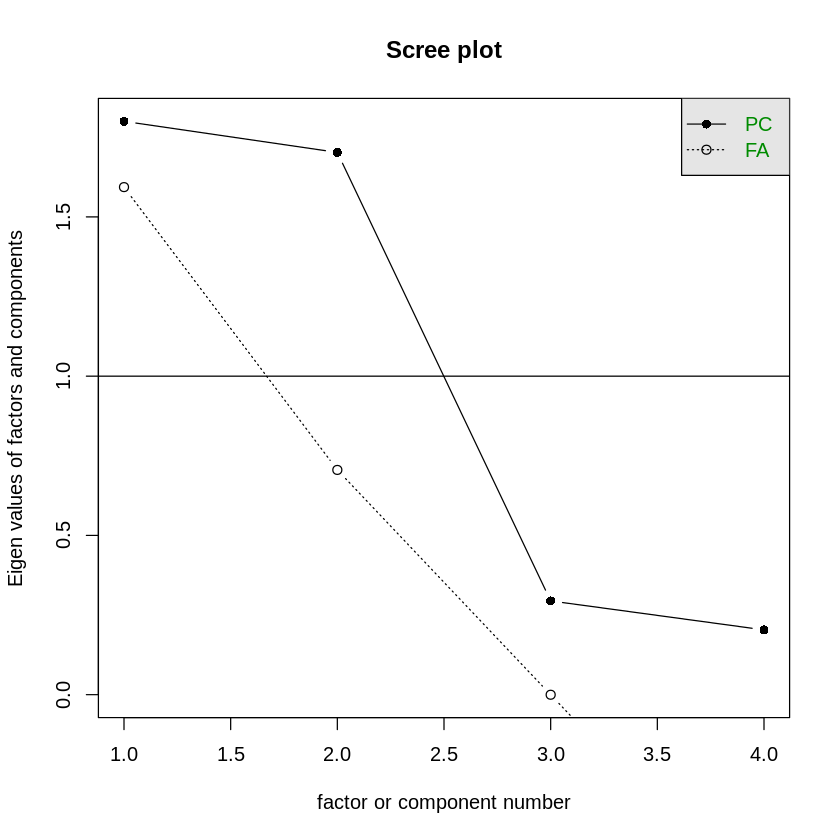

Parallel analysis suggests that the number of factors =  2  and the number of components =  NA 


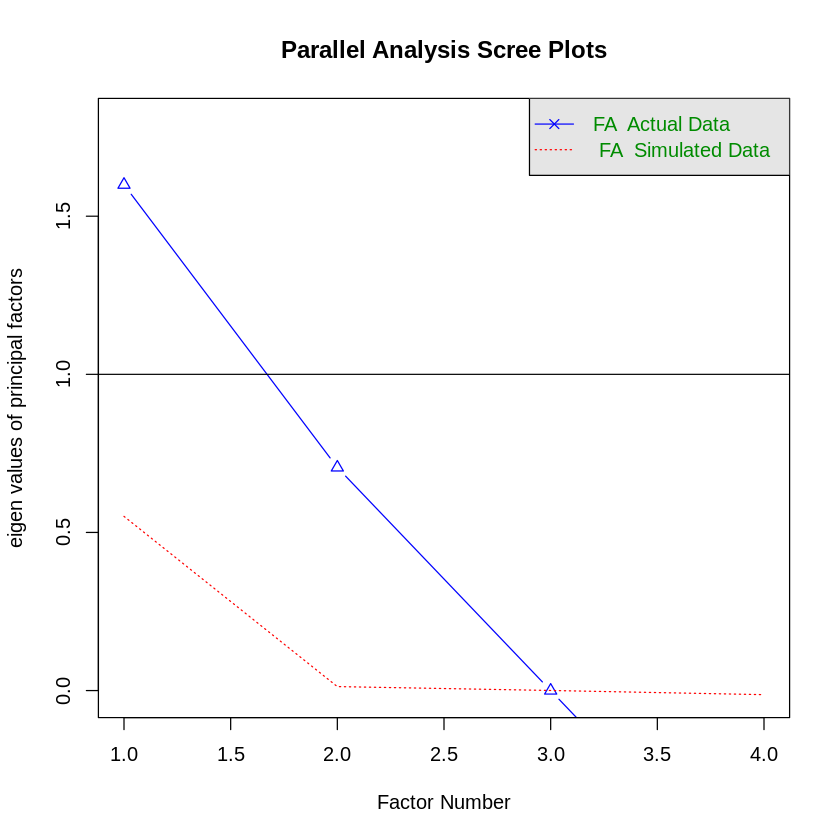

In [ ]:
#Gráfico de sedimentación con la regla de Kaiser marcada:
scree(matriz_correlaciones)
#Análisis paralelo:
fa.parallel(matriz_correlaciones, n.obs=nrow(datos_AFE), n.iter=500, fa="fa", fm="ml")
#Hemos indicado que cree 500 muestras aleatorias y que vamos a usar ML como método de extracción de factores.

El Análisis Paralelo sugiere la extracción de dos factores y la regla de Kaiser, de 1.

Haremos caso al Análisis Paralelo, por ser la técnica más recomendada actualmente. Además está en línea con los que esperábamos teóricamente.

### Paso 5: Extracción de factores + rotación:
Vamos a extraer dos factores, siguiendo lo recomendado por el Análisis Paralelo.

Asimismo, debemos decidir si vamos a rotar los factores y qué tipo de rotación vamos a emplear. Los métodos de rotación facilitan la interpretación de los factores, ya que sin rotarlos, suele ser muy difíciles de interpretar, por lo que se recomienda el uso de dichas técnicas de rotación.

Existen dos tipos de rotación:
* Rotación oblicua: permite que los factores puedan tener correlación entre ellos. Tipo recomendado, ya que es el más cercano a la estructura real que deseamos explorar. Un ejemplo es el método *oblimin*.
* Rotación ortogonal: fuerza a los factores a que no puedan tener correlación entre ellos. Un ejemplo es el método *varimax*.

Probaremos los dos y nos quedaremos con la solución que mejor resultado arroje. Pero, ¿cómo determinamos qué solución factorial ajusta mejor?
* Fijándonos en los pesos factoriales: Cuanto mayor sea el peso factorial de un ítem en un factor mejor. Se aceptan pesos factoriales por encima de 0,4. En general, una buena solución presentará variables que pesan mucho en un factor y poco en el resto.
* Índices de bondad del ajuste. Existen unos cuantos, pero nos podemos fijar en RMSEA, SRMR, TLI y CFI. RMSEA y SRMR cuantos más bajos mejor (se aceptan valores por debajo de 0,08), y TLI y CFI cuantos más altos mejor (valores por encima de 0,95 se consideran muy buenos).

Factor Analysis using method =  ml
Call: fa(r = matriz_correlaciones, nfactors = 2, n.obs = nrow(datos_AFE), 
    rotate = "oblimin", fm = "ml", alpha = 0.05)
Standardized loadings (pattern matrix) based upon correlation matrix
            ML1   ML2   h2    u2 com
Altura     0.00  1.00 1.00 0.005   1
Peso      -0.01  0.70 0.49 0.513   1
Ganancias  1.00  0.00 1.00 0.005   1
Partidos   0.79 -0.01 0.62 0.375   1

                       ML1  ML2
SS loadings           1.62 1.48
Proportion Var        0.40 0.37
Cumulative Var        0.40 0.78
Proportion Explained  0.52 0.48
Cumulative Proportion 0.52 1.00

 With factor correlations of 
     ML1  ML2
ML1 1.00 0.02
ML2 0.02 1.00

Mean item complexity =  1
Test of the hypothesis that 2 factors are sufficient.

The degrees of freedom for the null model are  6  and the objective function was  1.64 with Chi Square of  4085.19
The degrees of freedom for the model are -1  and the objective function was  0 

The root mean square of the residuals (RMSR

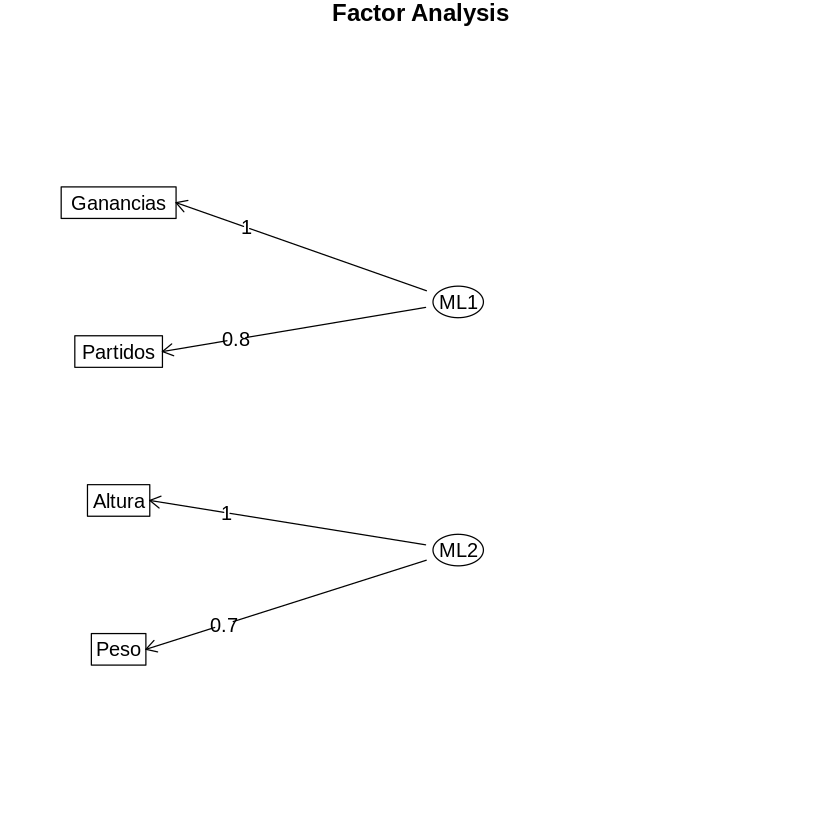

In [ ]:
#Con rotación oblicua oblimin:
AFE_oblimin <- fa(matriz_correlaciones, nfactors=2, n.obs=nrow(datos_AFE), rotate="oblimin", fm="ml", alpha=0.05)
AFE_oblimin
fa.diagram(AFE_oblimin)
#Vemos que los items que más pesan en el factor 1 son los correspondientes a las variables Ganancias y Partidos
#Los items que más pesan en el factor 2 son los correspondientes a las variables Altura y Peso
#Los índices de bondad del ajuste son muy buenos: RMSEA es inferior a 0,08 y TLI mayor a 0,95
#En el gráfico vemos que los factores no están ligeramente correlacionados
#A los pesos factoriales de 1 (el de la variable Partidos en el Factor 1, y el de la variable Altura en el 2) se les denomina "casos Heywood". Lo ideal es no tenerlos, aunque, por suerte, no son superiores a 1, lo que ya sería incorrecto
#Como hemos visto que los factores no están correlacionados, es posible que estos casos Heywood que tenemos se deban a usar un método de rotación oblicuo, y no uno ortogonal

* Vemos que los items que más pesan en el factor 1 son los correspondientes a las variables Ganancias y Partidos. Mientras que los items que más pesan en el factor 2 son los correspondientes a las variables Altura y Peso
* Los índices de bondad del ajuste son muy buenos: RMSEA es inferior a 0,08 y TLI mayor a 0,95
* En el gráfico vemos que los factores no están ligeramente correlacionados
* A los pesos factoriales de 1 (el de la variable Partidos en el Factor 1, y el de la variable Altura en el 2) se les denomina "casos Heywood". Lo ideal es no tenerlos, aunque, por suerte, no son superiores a 1, lo que ya sería incorrecto. Como hemos visto que los factores no están correlacionados, es posible que estos casos Heywood que tenemos se deban a usar un método de rotación oblicuo, y no uno ortogonal.

Factor Analysis using method =  ml
Call: fa(r = matriz_correlaciones, nfactors = 2, n.obs = nrow(datos_AFE), 
    rotate = "varimax", fm = "ml", alpha = 0.05)
Standardized loadings (pattern matrix) based upon correlation matrix
           ML1   ML2   h2    u2 com
Altura    0.24  0.97 1.00 0.005 1.1
Peso      0.16  0.68 0.49 0.513 1.1
Ganancias 0.97 -0.22 1.00 0.005 1.1
Partidos  0.77 -0.18 0.62 0.375 1.1

                       ML1  ML2
SS loadings           1.62 1.48
Proportion Var        0.41 0.37
Cumulative Var        0.41 0.78
Proportion Explained  0.52 0.48
Cumulative Proportion 0.52 1.00

Mean item complexity =  1.1
Test of the hypothesis that 2 factors are sufficient.

The degrees of freedom for the null model are  6  and the objective function was  1.64 with Chi Square of  4085.19
The degrees of freedom for the model are -1  and the objective function was  0 

The root mean square of the residuals (RMSR) is  0 
The df corrected root mean square of the residuals is  NA 

The har

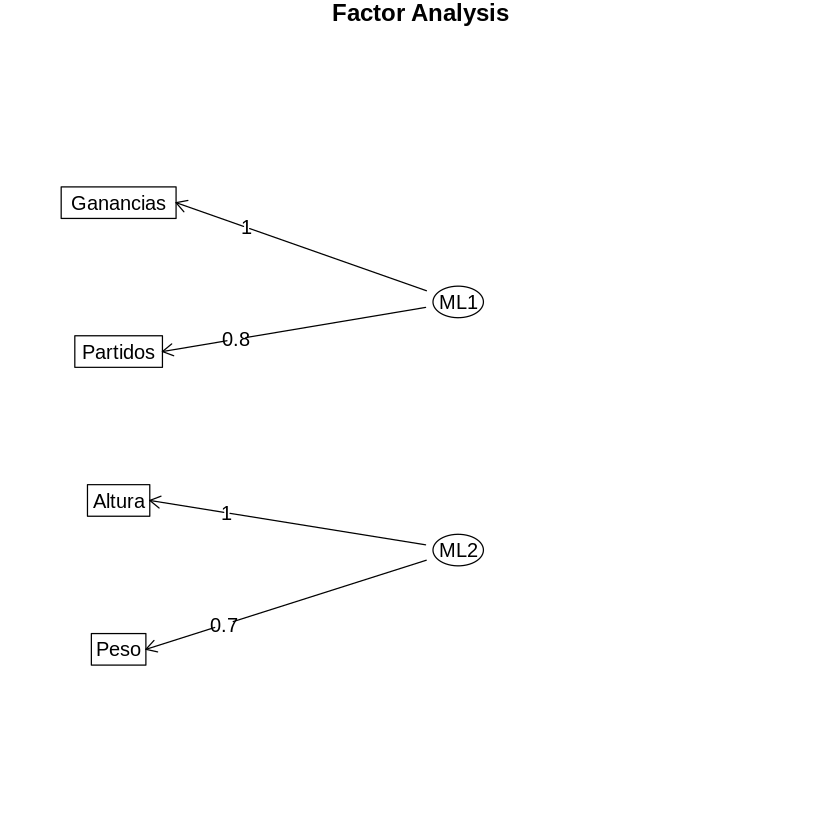

In [ ]:
#Con rotación ortogonal varimax:
AFE_varimax <- fa(matriz_correlaciones, nfactors=2, n.obs=nrow(datos_AFE), rotate="varimax", fm="ml", alpha=0.05)
AFE_varimax
fa.diagram(AFE_varimax)

* Vemos que los resultados son caso idénticos, salvo porque se solucionan los casos Heywood.
* Como los factores no estaban correlacionados, tenía más sentido usar una rotación ortogonal.

### Paso 6: interpretar los factores:
Intentamos darle nombre a los factores, facilitando la interpretación de los resultados.

Con respecto a nuestro ejemplo, en primer lugar, debemos decir que la estructura factorial obtenida concuerda con la estructura factorial teórica de dos factores.

Estos dos factores serían:
* Factor 1: variables Altura y Peso. Factor "físico".
* Factor 2: variables Ganancias y Partidos. Factor "económico-deportivo".